In [1]:
import sys

sys.path.append("..")

In [2]:
import random

import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib

from src.util import *
from src.model import *

tqdm.pandas()

In [3]:
last_review_date = pd.to_datetime("2015/01/01")
train_split_date = pd.to_datetime("2017/01/01")
test_split_date = pd.to_datetime("2018/01/01")

seed = 0
random.seed(seed)
np.random.seed(seed)

In [4]:
interaction_df, user_le, item_le = load_interaction_df(
    last_review_date=last_review_date,
    train_split_date=train_split_date,
)
items = item_le.transform(item_le.classes_)

(
    train_dataset,
    test_dataset,
    train_user_feature_table,
    test_user_feature_table,
) = create_dataset(
    interaction_df=interaction_df,
    train_split_date=train_split_date,
    test_split_date=test_split_date,
)

100%|██████████| 25093/25093 [00:00<00:00, 259836.79it/s]


In [ ]:
class Model(torch.nn.Module):
    def __init__(
        self,
        item_size: int,
        user_feature_dim: int,
        num_layers: int = 4,
        d_model: int = 64,
        dim_feedforward: int = 128,
        nhead: int = 4,
    ) -> None:
        super().__init__()
        self.user_embedding = torch.nn.Linear(user_feature_dim, d_model)
        self.item_embedding = torch.nn.Embedding(item_size, d_model)

        self.transformer_layer = torch.nn.TransformerEncoder(
            encoder_layer=torch.nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                batch_first=True,
            ),
            num_layers=num_layers,
        )
        self.clv_layer = TwoFeedForwardLayer(d_model, d_model // 2, 1)
        self.target_layer = TwoFeedForwardLayer(d_model, d_model // 2, 1)

    def forward(
        self, user_features: torch.Tensor, item_indices: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor]:
        e_u = self.user_embedding.forward(user_features)
        H_v = self.item_embedding.forward(item_indices)
        H = torch.cat((e_u.unsqueeze(1), H_v), dim=1)
        H = self.transformer_layer.forward(H)

        y_clv = torch.sigmoid(self.clv_layer.forward(H[:, 0]))
        y_target = torch.sigmoid(self.target_layer.forward(H[:, -1]))

        return y_clv.squeeze(), y_target.squeeze()

In [ ]:
def run_one_round(
    model: Model,
    dataloader: torch.utils.data.DataLoader,
    user_feature_table: np.ndarray,
    optimizer: torch.optim.Optimizer,
    args: Args,
    items: list[int],
    is_eval: bool = False,
) -> dict:
    result: dict[str, dict] = {
        "target": {"loss": 0.0, "y_pred": [], "y_true": []},
        "clv": {"loss": 0.0, "y_pred": [], "y_true": []},
    }

    if is_eval:
        model.eval()
    else:
        model.train()

    for batch in tqdm(dataloader):
        user_ids = []
        item_indices = []
        target_labels = []
        clv_labels = []

        for (user_id, user_context_items), target_items, clv in batch:
            context_items = []
            for _ in range(args.context_item_size):
                context_items.append(
                    user_context_items[random.randrange(len(user_context_items))]
                )

            # 正例
            for _ in range(min(args.negative_sample_size, len(target_items))):
                v = list(context_items)
                v.append(target_items[random.randrange(0, len(target_items))])
                user_ids.append(user_id)
                item_indices.append(v)
                target_labels.append(1)
                clv_labels.append(clv)

            # 負例
            for _ in range(args.negative_sample_size):
                v = list(context_items)
                v.append(items[random.randrange(len(items))])
                user_ids.append(user_id)
                item_indices.append(v)
                target_labels.append(0)
                clv_labels.append(clv)

        user_features = torch.FloatTensor(user_feature_table[user_ids]).to(args.device)
        item_indices = torch.LongTensor(item_indices).to(args.device)
        target_labels = torch.FloatTensor(target_labels).to(args.device)
        clv_labels = torch.FloatTensor(clv_labels).to(args.device)

        if is_eval:
            with torch.no_grad():
                y_clv, y_target = model.forward(user_features, item_indices)
        else:
            y_clv, y_target = model.forward(user_features, item_indices)

        target_loss = torch.nn.functional.binary_cross_entropy(y_target, target_labels)
        clv_loss = torch.nn.functional.binary_cross_entropy(y_clv, clv_labels)
        loss = target_loss * args.alpha + clv_loss * (1 - args.alpha)

        if not is_eval:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        result["target"]["loss"] += target_loss.item()
        result["target"]["y_pred"].extend(y_target.tolist())
        result["target"]["y_true"].extend(target_labels.tolist())
        result["clv"]["loss"] += clv_loss.item()
        result["clv"]["y_pred"].extend(y_clv.tolist())
        result["clv"]["y_true"].extend(clv_labels.tolist())

    for term_name in result.keys():
        result[term_name]["loss"] /= len(dataloader)

    return result


def train(
    model: Model,
    train_dataset: Dataset,
    test_dataset: Dataset,
    train_user_feature_table: np.ndarray,
    test_user_feature_table: np.ndarray,
    args: Args,
    items: list[int],
) -> tuple[list[dict], list[dict]]:
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        collate_fn=lambda x: x,  # 各データは形式が異なるため、バッチ化せずにそのまま返す
    )
    test_dataloader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda x: x,  # 各データは形式が異なるため、バッチ化せずにそのまま返す
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    train_results = []
    test_results = []

    for epoch in range(args.epochs):
        print(f"[epoch: {epoch + 1}/{args.epochs}]")
        result = run_one_round(
            model=model,
            dataloader=train_dataloader,
            user_feature_table=train_user_feature_table,
            optimizer=optimizer,
            args=args,
            items=items,
        )
        print(
            f"[train][loss] target_loss: {result['target']['loss']:.6f}, clv_loss: {result['clv']['loss']:.6f}"
        )
        train_results.append(result)

        result = run_one_round(
            model=model,
            dataloader=test_dataloader,
            user_feature_table=test_user_feature_table,
            optimizer=optimizer,
            args=args,
            items=items,
            is_eval=True,
        )
        print(
            f"[test][loss] target_loss: {result['target']['loss']:.6f}, clv_loss: {result['clv']['loss']:.6f}"
        )
        test_results.append(result)

    return train_results, test_results

In [5]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

target_loss_weight = 1
clv_loss_weight = 1
alpha = target_loss_weight / (target_loss_weight + clv_loss_weight)

args = Args(
    d_model=32,
    batch_size=64,
    nhead=4,
    epochs=20,
    lr=1e-3,
    sample_size=5,
    alpha=alpha,
    device=device,
    model_path="model.model",
)

try:
    model = torch.load(args.model_path)
    print(f"loaded model from: {args.model_path}")
except FileNotFoundError:
    model = Model(
        item_size=len(item_le.classes_),
        user_feature_dim=train_user_feature_table.shape[1],
        d_model=args.d_model,
        nhead=args.nhead,
    )
model.to(args.device)
model.train()

print(f"args: {args}")
train_results, test_results = train(
    model=model,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    train_user_feature_table=train_user_feature_table,
    test_user_feature_table=test_user_feature_table,
    args=args,
    items=items,
)

torch.save(model, args.model_path)
print(f"saved model to: {args.model_path}")

args: Args(d_model=32, batch_size=64, nhead=4, epochs=20, lr=0.001, sample_size=5, negative_sample_size=5, alpha=0.5, context_item_size=10, device='mps', model_path='model_2.model')
[epoch: 1/20]


100%|██████████| 393/393 [00:37<00:00, 10.50it/s]


[train][loss] target_loss: 0.361554, clv_loss: 0.400938
[train][alpha_weighted_loss] target_loss: 0.180777, clv_loss: 0.200469


100%|██████████| 393/393 [00:05<00:00, 66.78it/s]


[test][loss] target_loss: 0.333452, clv_loss: 0.381253
[test][alpha_weighted_loss] target_loss: 0.166726, clv_loss: 0.190626
[epoch: 2/20]


100%|██████████| 393/393 [00:21<00:00, 18.31it/s]


[train][loss] target_loss: 0.329686, clv_loss: 0.379800
[train][alpha_weighted_loss] target_loss: 0.164843, clv_loss: 0.189900


100%|██████████| 393/393 [00:04<00:00, 85.24it/s]


[test][loss] target_loss: 0.323245, clv_loss: 0.374028
[test][alpha_weighted_loss] target_loss: 0.161622, clv_loss: 0.187014
[epoch: 3/20]


100%|██████████| 393/393 [00:18<00:00, 21.83it/s]


[train][loss] target_loss: 0.305699, clv_loss: 0.374327
[train][alpha_weighted_loss] target_loss: 0.152849, clv_loss: 0.187164


100%|██████████| 393/393 [00:04<00:00, 82.19it/s]


[test][loss] target_loss: 0.304344, clv_loss: 0.378655
[test][alpha_weighted_loss] target_loss: 0.152172, clv_loss: 0.189327
[epoch: 4/20]


100%|██████████| 393/393 [00:19<00:00, 20.50it/s]


[train][loss] target_loss: 0.272464, clv_loss: 0.371453
[train][alpha_weighted_loss] target_loss: 0.136232, clv_loss: 0.185727


100%|██████████| 393/393 [00:04<00:00, 83.40it/s]


[test][loss] target_loss: 0.292602, clv_loss: 0.380163
[test][alpha_weighted_loss] target_loss: 0.146301, clv_loss: 0.190082
[epoch: 5/20]


100%|██████████| 393/393 [00:18<00:00, 21.18it/s]


[train][loss] target_loss: 0.246482, clv_loss: 0.368655
[train][alpha_weighted_loss] target_loss: 0.123241, clv_loss: 0.184327


100%|██████████| 393/393 [00:04<00:00, 85.15it/s]


[test][loss] target_loss: 0.270356, clv_loss: 0.374709
[test][alpha_weighted_loss] target_loss: 0.135178, clv_loss: 0.187355
[epoch: 6/20]


100%|██████████| 393/393 [00:17<00:00, 22.45it/s]


[train][loss] target_loss: 0.227416, clv_loss: 0.365730
[train][alpha_weighted_loss] target_loss: 0.113708, clv_loss: 0.182865


100%|██████████| 393/393 [00:04<00:00, 84.14it/s]


[test][loss] target_loss: 0.268896, clv_loss: 0.379036
[test][alpha_weighted_loss] target_loss: 0.134448, clv_loss: 0.189518
[epoch: 7/20]


100%|██████████| 393/393 [00:18<00:00, 21.74it/s]


[train][loss] target_loss: 0.208032, clv_loss: 0.362713
[train][alpha_weighted_loss] target_loss: 0.104016, clv_loss: 0.181357


100%|██████████| 393/393 [00:04<00:00, 84.40it/s]


[test][loss] target_loss: 0.252455, clv_loss: 0.370155
[test][alpha_weighted_loss] target_loss: 0.126228, clv_loss: 0.185078
[epoch: 8/20]


100%|██████████| 393/393 [00:17<00:00, 21.93it/s]


[train][loss] target_loss: 0.193143, clv_loss: 0.359089
[train][alpha_weighted_loss] target_loss: 0.096572, clv_loss: 0.179545


100%|██████████| 393/393 [00:04<00:00, 84.92it/s]


[test][loss] target_loss: 0.240770, clv_loss: 0.373250
[test][alpha_weighted_loss] target_loss: 0.120385, clv_loss: 0.186625
[epoch: 9/20]


100%|██████████| 393/393 [00:17<00:00, 21.89it/s]


[train][loss] target_loss: 0.181792, clv_loss: 0.356461
[train][alpha_weighted_loss] target_loss: 0.090896, clv_loss: 0.178231


100%|██████████| 393/393 [00:04<00:00, 84.45it/s]


[test][loss] target_loss: 0.236416, clv_loss: 0.370246
[test][alpha_weighted_loss] target_loss: 0.118208, clv_loss: 0.185123
[epoch: 10/20]


100%|██████████| 393/393 [00:18<00:00, 21.09it/s]


[train][loss] target_loss: 0.170580, clv_loss: 0.350409
[train][alpha_weighted_loss] target_loss: 0.085290, clv_loss: 0.175204


100%|██████████| 393/393 [00:04<00:00, 82.86it/s]


[test][loss] target_loss: 0.228899, clv_loss: 0.370152
[test][alpha_weighted_loss] target_loss: 0.114450, clv_loss: 0.185076
[epoch: 11/20]


100%|██████████| 393/393 [00:17<00:00, 22.44it/s]


[train][loss] target_loss: 0.162265, clv_loss: 0.348473
[train][alpha_weighted_loss] target_loss: 0.081133, clv_loss: 0.174236


100%|██████████| 393/393 [00:04<00:00, 82.07it/s]


[test][loss] target_loss: 0.220662, clv_loss: 0.358487
[test][alpha_weighted_loss] target_loss: 0.110331, clv_loss: 0.179243
[epoch: 12/20]


100%|██████████| 393/393 [00:18<00:00, 21.51it/s]


[train][loss] target_loss: 0.155553, clv_loss: 0.343602
[train][alpha_weighted_loss] target_loss: 0.077777, clv_loss: 0.171801


100%|██████████| 393/393 [00:04<00:00, 79.60it/s]


[test][loss] target_loss: 0.219682, clv_loss: 0.350067
[test][alpha_weighted_loss] target_loss: 0.109841, clv_loss: 0.175034
[epoch: 13/20]


100%|██████████| 393/393 [00:17<00:00, 22.12it/s]


[train][loss] target_loss: 0.152385, clv_loss: 0.340351
[train][alpha_weighted_loss] target_loss: 0.076193, clv_loss: 0.170176


100%|██████████| 393/393 [00:04<00:00, 84.64it/s]


[test][loss] target_loss: 0.231672, clv_loss: 0.358816
[test][alpha_weighted_loss] target_loss: 0.115836, clv_loss: 0.179408
[epoch: 14/20]


100%|██████████| 393/393 [00:18<00:00, 21.76it/s]


[train][loss] target_loss: 0.146338, clv_loss: 0.339940
[train][alpha_weighted_loss] target_loss: 0.073169, clv_loss: 0.169970


100%|██████████| 393/393 [00:04<00:00, 84.61it/s]


[test][loss] target_loss: 0.218343, clv_loss: 0.351302
[test][alpha_weighted_loss] target_loss: 0.109172, clv_loss: 0.175651
[epoch: 15/20]


100%|██████████| 393/393 [00:18<00:00, 21.56it/s]


[train][loss] target_loss: 0.142561, clv_loss: 0.336211
[train][alpha_weighted_loss] target_loss: 0.071281, clv_loss: 0.168106


100%|██████████| 393/393 [00:04<00:00, 84.57it/s]


[test][loss] target_loss: 0.221633, clv_loss: 0.360044
[test][alpha_weighted_loss] target_loss: 0.110816, clv_loss: 0.180022
[epoch: 16/20]


100%|██████████| 393/393 [00:20<00:00, 19.58it/s]


[train][loss] target_loss: 0.140882, clv_loss: 0.335411
[train][alpha_weighted_loss] target_loss: 0.070441, clv_loss: 0.167705


100%|██████████| 393/393 [00:04<00:00, 84.18it/s]


[test][loss] target_loss: 0.225099, clv_loss: 0.366678
[test][alpha_weighted_loss] target_loss: 0.112550, clv_loss: 0.183339
[epoch: 17/20]


100%|██████████| 393/393 [00:18<00:00, 21.37it/s]


[train][loss] target_loss: 0.137742, clv_loss: 0.333696
[train][alpha_weighted_loss] target_loss: 0.068871, clv_loss: 0.166848


100%|██████████| 393/393 [00:04<00:00, 83.97it/s]


[test][loss] target_loss: 0.221798, clv_loss: 0.349238
[test][alpha_weighted_loss] target_loss: 0.110899, clv_loss: 0.174619
[epoch: 18/20]


100%|██████████| 393/393 [00:18<00:00, 21.51it/s]


[train][loss] target_loss: 0.135257, clv_loss: 0.328553
[train][alpha_weighted_loss] target_loss: 0.067628, clv_loss: 0.164276


100%|██████████| 393/393 [00:04<00:00, 83.70it/s]


[test][loss] target_loss: 0.235953, clv_loss: 0.372125
[test][alpha_weighted_loss] target_loss: 0.117976, clv_loss: 0.186062
[epoch: 19/20]


100%|██████████| 393/393 [00:19<00:00, 20.41it/s]


[train][loss] target_loss: 0.133598, clv_loss: 0.329670
[train][alpha_weighted_loss] target_loss: 0.066799, clv_loss: 0.164835


100%|██████████| 393/393 [00:04<00:00, 82.85it/s]


[test][loss] target_loss: 0.224108, clv_loss: 0.350533
[test][alpha_weighted_loss] target_loss: 0.112054, clv_loss: 0.175267
[epoch: 20/20]


100%|██████████| 393/393 [00:18<00:00, 21.18it/s]


[train][loss] target_loss: 0.131160, clv_loss: 0.330185
[train][alpha_weighted_loss] target_loss: 0.065580, clv_loss: 0.165092


100%|██████████| 393/393 [00:04<00:00, 84.21it/s]


[test][loss] target_loss: 0.225462, clv_loss: 0.356081
[test][alpha_weighted_loss] target_loss: 0.112731, clv_loss: 0.178041
saved model to: model_2.model


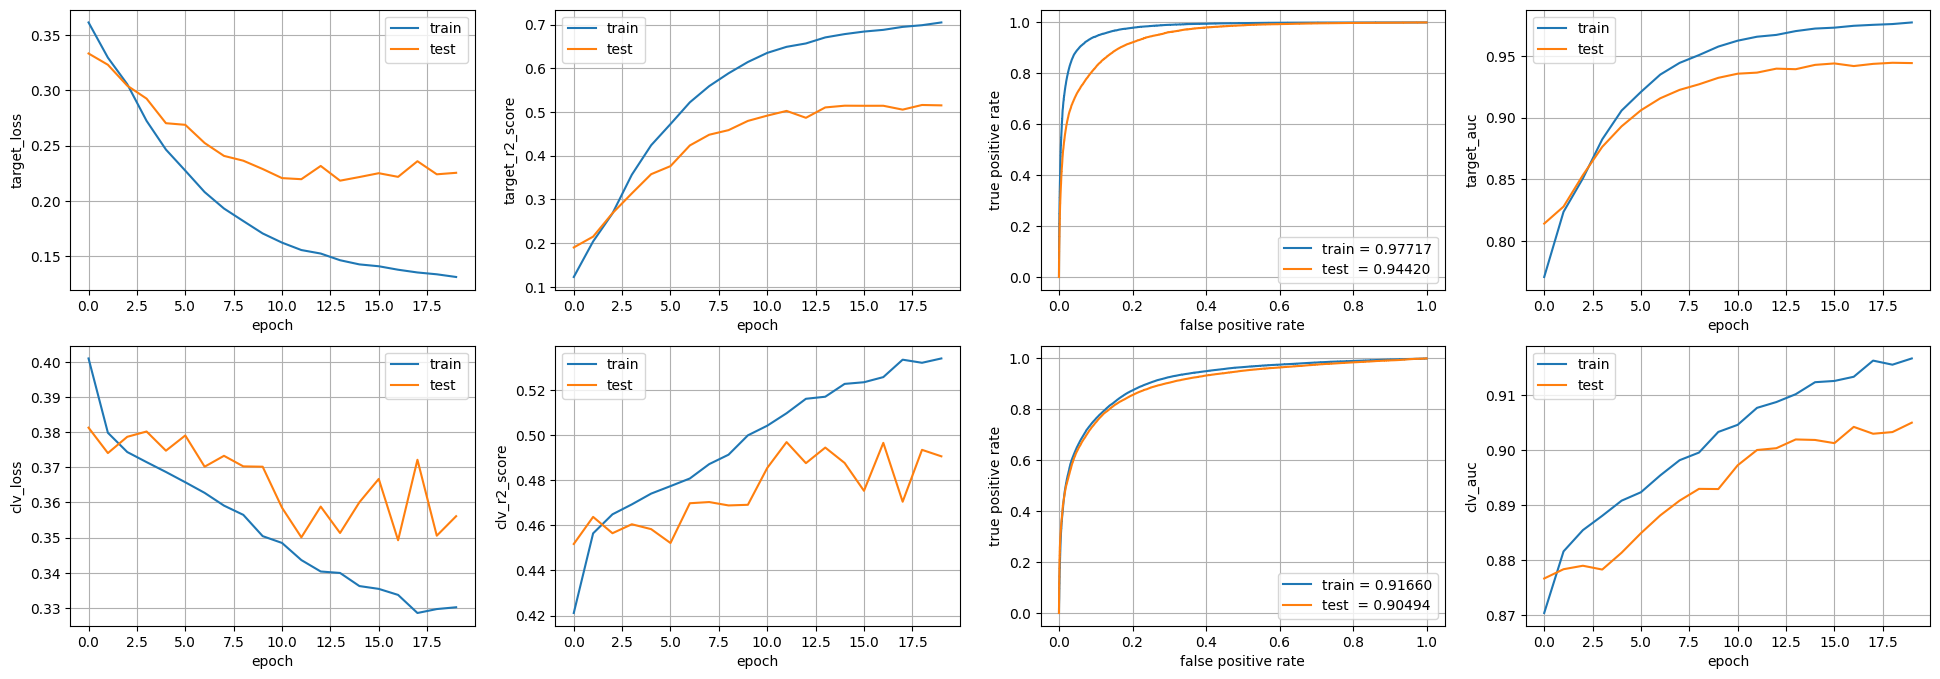

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 8))
loss_names = ["target", "clv"]

for i, loss_name in enumerate(loss_names):
    plot_loss(train_results, test_results, loss_name, axes[i, 0])
    plot_r2_score(train_results, test_results, loss_name, axes[i, 1])
    plot_roc_auc(train_results[-1], test_results[-1], loss_name, axes[i, 2])
    plot_auc(train_results, test_results, loss_name, axes[i, 3])

plt.show()

In [7]:
model.eval()

filter_sample_size = 10
sample_size = 100

for (user_id, user_context_items), target_items, clv in test_dataset:
    if len(target_items) == 0:
        continue

    b = None
    for _ in range(filter_sample_size):
        user_ids = []
        item_indices = []

        context_items = []
        for _ in range(args.context_item_size):
            context_items.append(user_context_items[random.randrange(len(user_context_items))])

        for target in items:
            v = list(context_items)
            v.append(target)
            user_ids.append(user_id)
            item_indices.append(v)

        user_features = torch.FloatTensor(test_user_feature_table[user_ids]).to(args.device)
        item_indices = torch.LongTensor(item_indices).to(args.device)

        with torch.no_grad():
            y_clv, y_target = model.forward(user_features, item_indices)

        a = y_target.cpu().detach().numpy()
        if b is None:
            b = a
        else:
            b += a

    b /= filter_sample_size
    filtered_items = items[np.argsort(b)][::-1][:100] # 降順でソートし、上位100件を取得する
    print("before rerank:", len(set(filtered_items[:10]) & set(target_items)), "/", len(target_items))

    clv_sum = []
    for item in filtered_items:
        user_ids = []
        item_indices = []

        for _ in range(sample_size):
            context_items = []
            for _ in range(args.context_item_size):
                context_items.append(user_context_items[random.randrange(len(user_context_items))])

            v = list(context_items)
            v.append(item)
            user_ids.append(user_id)
            item_indices.append(v)

        user_features = torch.FloatTensor(test_user_feature_table[user_ids]).to(args.device)
        item_indices = torch.LongTensor(item_indices).to(args.device)

        with torch.no_grad():
            y_clv, y_target = model.forward(user_features, item_indices)

        clv_sum.append(y_clv.sum().item())

    recommendation = filtered_items[np.argsort(clv_sum)][::-1]
    print("after rerank:", len(set(recommendation[:10]) & set(target_items)), "/", len(target_items))

before rerank: 2 / 155
after rerank: 1 / 155
before rerank: 0 / 3
after rerank: 0 / 3
before rerank: 0 / 15


KeyboardInterrupt: 